
### Projeto de LDA com análise de sentimentos em português 

In [1]:
#!pip install numpy==1.20.0
#!pip install pyLDAvis

In [2]:
%pylab inline

import pandas as pd
import pickle as pk
from bs4 import BeautifulSoup
from scipy import sparse as sp

Populating the interactive namespace from numpy and matplotlib


In [3]:
path='../datasets/'
data = pd.read_csv(path+'tw_pt.csv', usecols=['Text', 'Classificacao'])


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8199 entries, 0 to 8198
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Text           8199 non-null   object
 1   Classificacao  8199 non-null   object
dtypes: object(2)
memory usage: 128.2+ KB


In [5]:
data.head()

,Text,Classificacao
0,���⛪ @ Catedral de Santo Antônio - Governador ...,Neutro
1,"� @ Governador Valadares, Minas Gerais https:/...",Neutro
2,"�� @ Governador Valadares, Minas Gerais https:...",Neutro
3,��� https://t.co/BnDsO34qK0,Neutro
4,��� PSOL vai questionar aumento de vereadores ...,Negativo


**Pré Pré-processamento da Base para remover caracteres especiais mantendo a acentuação**


In [6]:
def clean_text(s):
    #if type(s)!=str:
     #return ""
    s = re.sub(r'-', ' ', s)    
    s = re.sub(r'/MG', ' MG ', s)    # substitui ?MG por ' MG '    
    s = re.sub('(RT|via)((?:\\b\\W*@\\w+)+)', ' ', s) # remove re-tweet
    s = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', s)  # remove hash tags
    s = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', s)  # remove tweeted at
    s = re.sub(r'-', ' ', s)    
    special_char_pattern = re.compile(r'([{.(-)!}])')
    pattern = r'[^a-zA-z0-9áéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ\s]' # remove os caracteres especiais mantendo a acentuação em português
    s = re.sub(pattern, '', s)
    s = special_char_pattern.sub(" \\1 ", s)    
    s = re.sub(r"http[s]?://\S+", "", s)
    s = re.sub(r'http\S+', '', s)
    s = re.sub('([0-9]+)', '', s)  # remove numbers
    s = re.sub(r'@\S+', '', s)
    s = re.sub('&amp', ' ', s)
    s = re.sub(r'[\r|\n|\r\n]+', ' ', s)
    s = re.sub(' +', ' ', s)
    soup = BeautifulSoup(s, "html.parser")
    s = soup.get_text()
    s = re.sub(r"\s+"," ",s).strip()
    
    return s

data['Text'] = data['Text'].apply(clean_text).str.lower()

In [7]:
data.head()

,Text,Classificacao
0,catedral de santo antônio governador valadares mg,Neutro
1,governador valadares minas gerais,Neutro
2,governador valadares minas gerais,Neutro
3,,Neutro
4,psol vai questionar aumento de vereadores e pr...,Negativo


In [8]:
docs = array(data['Text'])
docs[1]

'governador valadares minas gerais'

## Aplicando Tokenização

In [9]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\FABIO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
      #  docs[idx] = str(docs[idx]).lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
   # lemmatizer = WordNetLemmatizer()
   # docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs

In [11]:
docs = docs_preprocessor(docs)

### **Computar bigramas e trigramas :**
Qunado os tópicos são muito semelhantes, o que os diferencia são frases ao invés de palavras únicas / individuais.

In [12]:
from gensim.models import Phrases
# Add bigrams and trigrams to docs (only ones that appear 10 times or more).
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

C:\Users\FABIO\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [13]:
print(trigram)

Phrases<17887 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>


### Remover Tokens comuns e pouco comuns

In [14]:
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
print('Number of unique words in initital documents:', len(dictionary))

# Filter out words that occur less than 10 documents, or more than 20% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.2)
print('Number of unique words after removing rare and common words:', len(dictionary))

Number of unique words in initital documents: 6408
Number of unique words after removing rare and common words: 1335


**Vetorizar dados:**

A primeira etapa é obter uma representação por trás das palavras de cada documento.
Passos:

1-converter um corpus
doc2bow:converter documento (uma lista de palavras) no formato de bag of words = lista de (token_id, token_count)

2-tuplas. Cada palavra é considerada uma string tokenizada e normalizada (codificada em unicode ou em utf8).
Nenhum outro pré-processamento é feito nas palavras do documento; aplique tokenização, lematização etc.
antes de chamar esse método.


In [15]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [16]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 1335
Number of documents: 8199




Com o corpus de bag of words, podemos prosseguir para aprender nosso modelo de tópico a partir dos documentos.

# Treinando o LDA



In [17]:
from gensim.models import LdaModel

In [18]:
# Set training parameters.
num_topics = 4
chunksize = 500 # size of the doc looked at every pass
passes = 200 # number of passes through documents
iterations = 400 # Maximum number of iterations through the corpus when inferring the topic distribution of a corpus
eval_every = 0  #  evaluate model perplexity.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

Wall time: 1min 56s


# Como escolher a quantidade de tópicos?
__LDA__ é uma técnica não supervisionada, o que significa que não sabemos antes de executar o modelo quantos tópicos existem em nosso corpus. A coerência do tópico é uma das principais técnicas utilizadas para estimar o número de tópicos. 

No entanto, usei a ferramenta de visualização LDA **pyLDAvis**, tentei alguns tópicos e comparei os resultados. Seis pareciam ser o número ideal de tópicos que separariam mais os tópicos.

In [19]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [20]:
pyLDAvis.gensim_models.prepare(model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.078846  0.356809       1        1  32.742835
3      0.136965 -0.235074       2        1  22.748863
2      0.174170 -0.076948       3        1  22.689761
1     -0.389982 -0.044787       4        1  21.818541, topic_info=                       Term         Freq        Total Category  logprob  \
38        dois_helicópteros  1867.000000  1867.000000  Default  30.0000   
116   calamidade_financeira  1544.000000  1544.000000  Default  29.0000   
143                  drogas  1298.000000  1298.000000  Default  28.0000   
1090            gerais_teve   926.000000   926.000000  Default  27.0000   
115              calamidade   900.000000   900.000000  Default  26.0000   
...                     ...          ...          ...      ...      ...   
1205         suspeito_roubo   117.749831   118.478813   Topic4  -5.0593   
1286       ônibus_carregado   113.734381   114.448585   Topic4  -5.0940   
57                     mais   875.552979   944.000113   Topic4  -3.0530   
900                suspeito   187.733167   350.560848   Topic4  -4.5929   
246                   preso   220.875781   537.332693   Topic4  -4.4303   

      loglift  
38    30.0000  
116   29.0000  
143   28.0000  
1090  27.0000  
115   26.0000  
...       ...  
1205   1.5162  
1286   1.5162  
57     1.4471  
900    0.8979  
246    0.6334  

[170 rows x 6 columns], token_table=      Topic      Freq                            Term
term                                                 
1265      1  0.994689                           adota
1266      1  0.998285                      adota_novo
1267      1  0.996162      adota_novo_modelo_consegue
319       1  0.794526                           ainda
319       2  0.205039                           ainda
...     ...       ...                             ...
1045      2  0.998975                vacinação_contra
1046      2  0.997091  vacinação_contra_febre_amarela
2         2  0.996011                       valadares
330       2  0.990104                            zona
1286      4  0.996080                ônibus_carregado

[155 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])

**O que vemos aqui? **

**O painel esquerdo**, rotulado Mapa de distância intertópica, os círculos representam diferentes tópicos e a distância entre eles. Tópicos semelhantes aparecem mais próximos e tópicos diferentes mais distantes.
O tamanho relativo do círculo de um tópico no gráfico corresponde à frequência relativa do tópico no corpus.
Um tópico individual pode ser selecionado para um exame mais detalhado clicando em seu círculo ou inserindo seu número na caixa "tópico selecionado" no canto superior esquerdo.
 
** O painel direito ** inclui o gráfico de barras dos 30 principais termos. Quando nenhum tópico é selecionado no gráfico à esquerda, o gráfico de barras mostra os 30 termos mais "destacados" no corpus. O destaque de um termo é uma medida de quão frequente o termo é no corpus e quão "distinto" ele é na distinção entre diferentes tópicos.
Selecionar cada tópico à direita modifica o gráfico de barras para mostrar os termos "relevantes" para o tópico selecionado.
A relevância é definida como no rodapé 2 e pode ser ajustada pelo parâmetro $ \ lambda $, menor $ \ lambda $ dá maior peso à distinção do termo, enquanto $ \ lambda $ s maior corresponde à probabilidade da ocorrência do termo por tópicos.

Portanto, para ter uma noção melhor dos termos por tópico, usaremos $ \ lambda $ = 0.

In [21]:
from collections import OrderedDict
def get_doc_topic_dist(model, corpus, kwords=False):
    
    '''
   A transformação LDA, para cada doc retorna apenas tópicos com peso diferente de zero
     Esta função faz uma transformação de matriz de documentos no espaço do tópico.
    '''
    top_dist =[]
    keys = []

    for d in corpus:
        tmp = {i:0 for i in range(num_topics)}
        tmp.update(dict(model[d]))
        vals = list(OrderedDict(tmp).values())
        top_dist += [array(vals)]
        if kwords:
            keys += [array(vals).argmax()]

    return array(top_dist), keys

###  Vejamos os termos que aparecem mais em cada tópico.

In [22]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

In [23]:
topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(model,topic_number=i, topn=10, output=True )
#     print tmp[:5]
    topic_summaries += [tmp[:4]]
    print

term                 frequency

Topic 0 |---------------------

drogas               0.047
tráfico_drogas       0.031
polícia              0.024
tráfico              0.023
recuperar_presos     0.019
polícia_civil        0.019
presos               0.017
juiz_fora            0.017
roubo                0.016
homem_preso          0.013
Topic 1 |---------------------

dois_helicópteros    0.101
calamidade_financeira 0.083
calamidade           0.049
mais                 0.047
dois                 0.045
helicópteros         0.044
mesmo_calamidade     0.040
financeira           0.039
compra               0.038
drogas_sintéticas    0.024
Topic 2 |---------------------

gerais_teve          0.048
presídio_privado     0.037
três_anos            0.034
avisa_justiça        0.033
recursos_conta       0.029
três                 0.028
gerais               0.026
fernando_pimentel    0.025
anos                 0.022
pimentel             0.020
Topic 3 |---------------------

amarela              0.030
fe


De cima, é possível inspecionar cada tópico e atribuir um rótulo interpretável por humanos a ele. Aqui, eu os rotulei da seguinte maneira:

In [24]:
top_labels = {0: 'Segurança', 1:'Variedades', 2:'Política',3:'Saúde'}

In [25]:
import re
import nltk
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

stops = set(stopwords.words('portuguese'))

def paper_to_wordlist( paper, remove_stopwords=False ):
    '''
        Function converts text to a sequence of words,
        Returns a list of words.
    '''
    lemmatizer = WordNetLemmatizer()
    # 1. Remove non-letters
    paper_text = re.sub("[^a-zA-Z]"," ", paper)
    # 2. Convert words to lower case and split them
    words = paper_text.split()
    # 3. Remove stop words
 #   words = [w for w in words if not w in stops]
    # 4. Remove short words
    words = [t for t in words if len(t) > 2]
    # 5. lemmatizing
    words = [nltk.stem.WordNetLemmatizer().lemmatize(t) for t in words]
   

    return(words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FABIO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Agora vamos mudar a representação TF-IDF

In [26]:
data.head()

,Text,Classificacao
0,catedral de santo antônio governador valadares mg,Neutro
1,governador valadares minas gerais,Neutro
2,governador valadares minas gerais,Neutro
3,,Neutro
4,psol vai questionar aumento de vereadores e pr...,Negativo


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

tvectorizer = TfidfVectorizer(input='content', analyzer = 'word', lowercase=True,\
                                  tokenizer=paper_to_wordlist, ngram_range=(1, 3), min_df=40, max_df=0.20,\
                                  norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True)

dtm = tvectorizer.fit_transform(data['Text']).toarray()

In [28]:
top_dist =[]
for d in corpus:
    tmp = {i:0 for i in range(num_topics)}
    tmp.update(dict(model[d]))
    vals = list(OrderedDict(tmp).values())
    top_dist += [array(vals)]

In [29]:
top_dist, lda_keys= get_doc_topic_dist(model, corpus, True)
features = tvectorizer.get_feature_names()

In [30]:
top_ws = []
for n in range(len(dtm)):
    inds = int0(argsort(dtm[n])[::-1][:4])
    tmp = [features[i] for i in inds]
    
    top_ws += [' '.join(tmp)]
    
data['Text_Rep'] = pd.DataFrame(top_ws)
data['clusters'] = pd.DataFrame(lda_keys)
data['clusters'].fillna(3, inplace=True)

cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 3: 'red'}

data['colors'] = data['clusters'].apply(lambda l: cluster_colors[l])

In [31]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(top_dist)

In [32]:
X_tsne.shape,len(data)

((8199, 2), 8199)

In [33]:
data['X_tsne'] =X_tsne[:, 0]
data['Y_tsne'] =X_tsne[:, 1]

In [34]:
from bokeh.plotting import figure, show, output_notebook, save#, output_file
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource
output_notebook()

Loading BokehJS ...

In [35]:
source = ColumnDataSource(dict(
    x=data['X_tsne'],
    y=data['Y_tsne'],
    color=data['colors'],
    label=data['clusters'].apply(lambda l: top_labels[l]),
    #msize= data['marker_size'],
    topic_key= data['clusters'],
    title= data[u'Classificacao'],
    content = data['Text_Rep']
))

In [36]:
title = 'T-SNE visualization of topics'

plot_lda = figure(plot_width=1000, plot_height=600,
                     title=title, tools="pan,wheel_zoom,box_zoom,reset,hover",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x='x', y='y', legend='label', source=source,
                 color='color', alpha=0.8, size=10)#'msize', )

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "Title: @title, KeyWords: @content - Topic: @topic_key "}
plot_lda.legend.location = "top_left"

show(plot_lda)

#save the plot
# save(plot_lda, '{}.html'.format(title))

### Agora temos labels para nossos grupos 

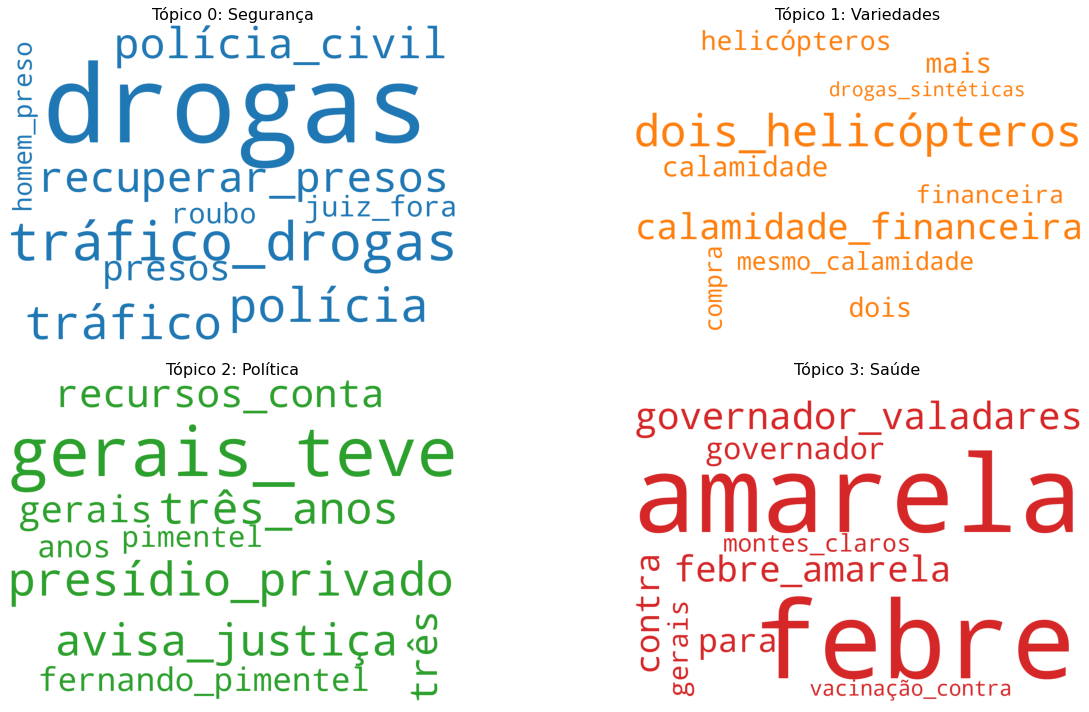

In [37]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=1250,
                  height=900,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=0.6)
topics = model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(20,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
  #  plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().set_title('Tópico '+ str(i)+ ': '+top_labels[i], fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()